## 1. Setup and Data Loading

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report,
                            precision_score, recall_score, f1_score,
                            roc_curve, roc_auc_score)
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from scipy.ndimage import shift, rotate, zoom
import joblib
import gradio as gr
import os

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)  # Convert labels to integers

# Split into train and test sets (60k train, 10k test)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 2. Model Training and Evaluation

In [4]:
# Function to train and evaluate models
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    # SGD Classifier with hinge loss (linear SVM)
    sgd_clf = SGDClassifier(loss='hinge', random_state=42, n_jobs=-1)
    sgd_clf.fit(X_train, y_train)

    # Random Forest Classifier
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_clf.fit(X_train, y_train)

    # Evaluate models
    models = {'SGD': sgd_clf, 'Random Forest': rf_clf}
    results = {}

    for name, model in models.items():
        y_pred = model.predict(X_test)
        # Generate y_scores on the test set
        y_scores = model.decision_function(X_test) if hasattr(model, "decision_function") else model.predict_proba(X_test)


        # Store results
        results[name] = {
            'accuracy': model.score(X_test, y_test),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred),
            'y_scores': y_scores
        }

    return models, results

# Train and evaluate models
models, results = train_and_evaluate_models(X_train, y_train, X_test, y_test)

# Print results
for name, result in results.items():
    print(f"\n{name} Classifier Results:")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print("\nClassification Report:")
    print(result['classification_report'])


SGD Classifier Results:
Accuracy: 0.8740

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       980
           1       0.97      0.96      0.97      1135
           2       0.93      0.78      0.85      1032
           3       0.78      0.92      0.84      1010
           4       0.96      0.79      0.87       982
           5       0.86      0.79      0.83       892
           6       0.96      0.89      0.93       958
           7       0.93      0.89      0.91      1028
           8       0.65      0.90      0.75       974
           9       0.84      0.87      0.86      1009

    accuracy                           0.87     10000
   macro avg       0.89      0.87      0.87     10000
weighted avg       0.89      0.87      0.88     10000


Random Forest Classifier Results:
Accuracy: 0.9705

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98 

## 3. Performance Metrics and Visualization


Visualizations for SGD Classifier:


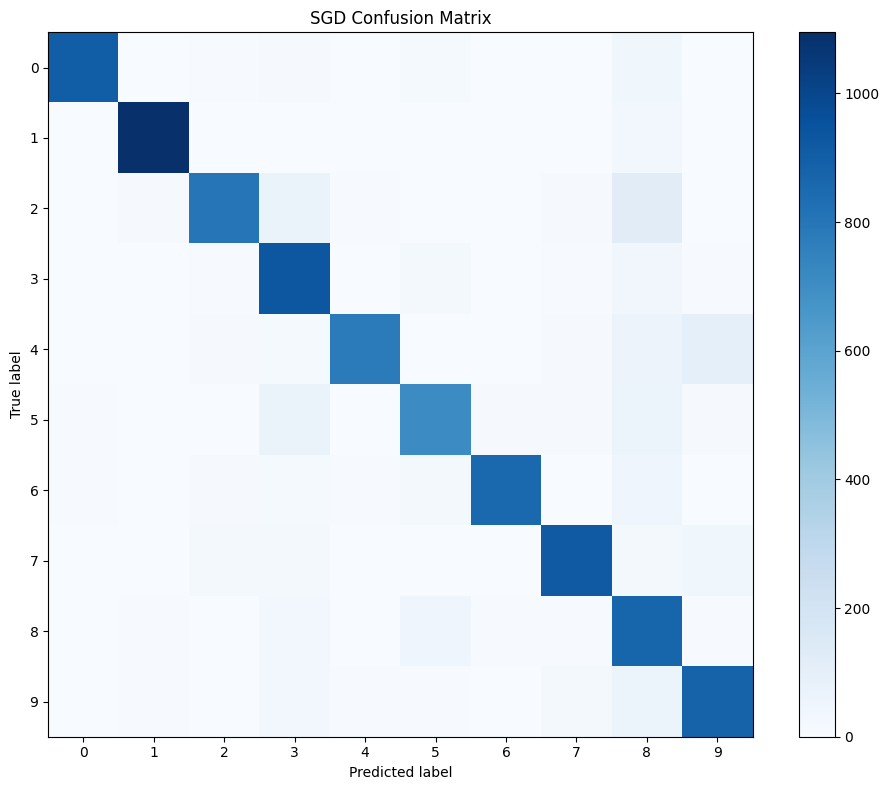

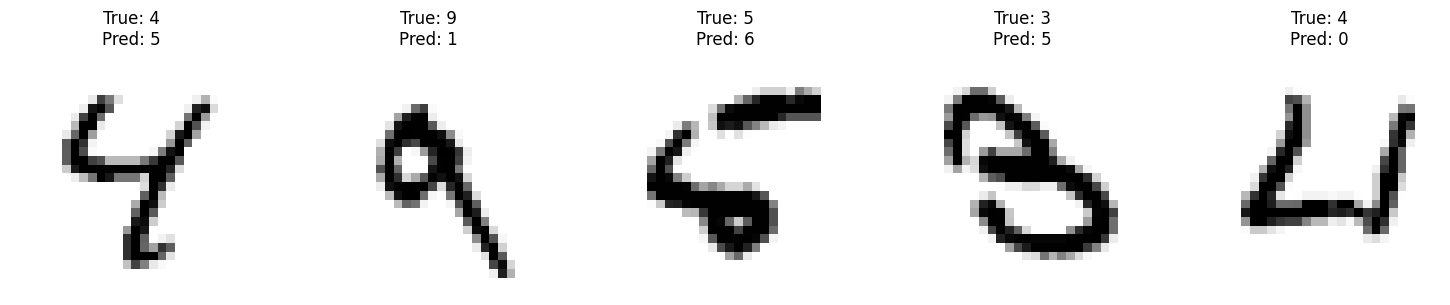

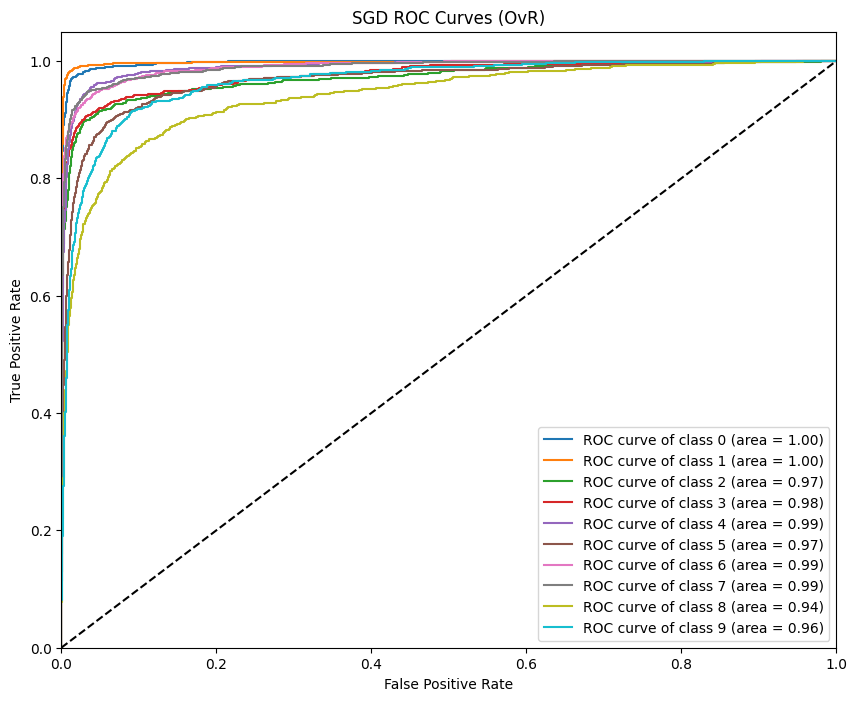


Visualizations for Random Forest Classifier:


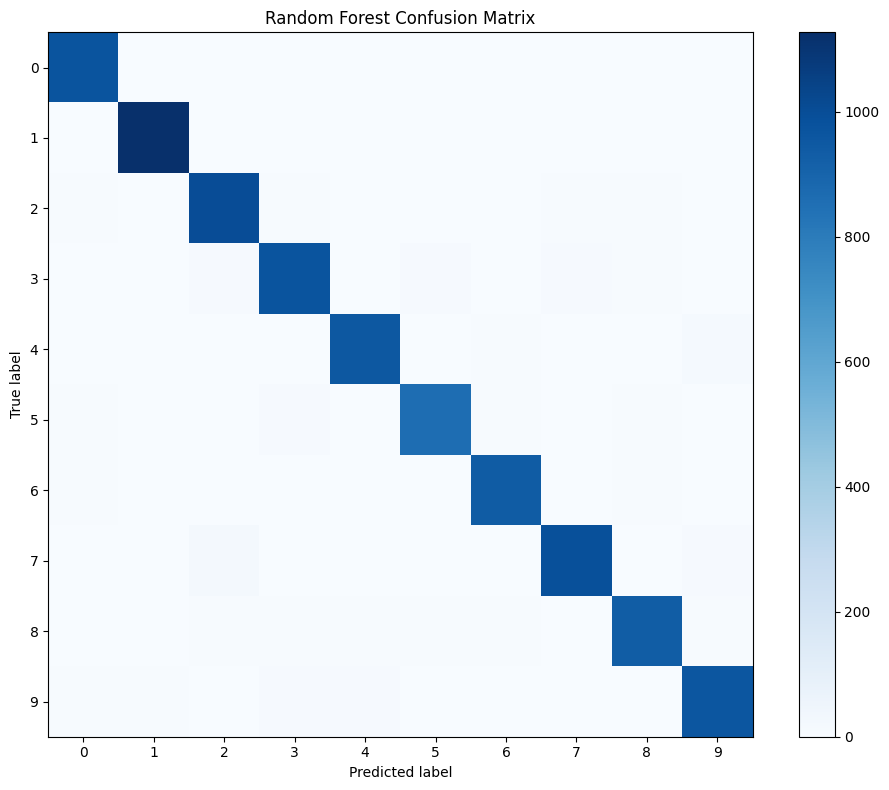

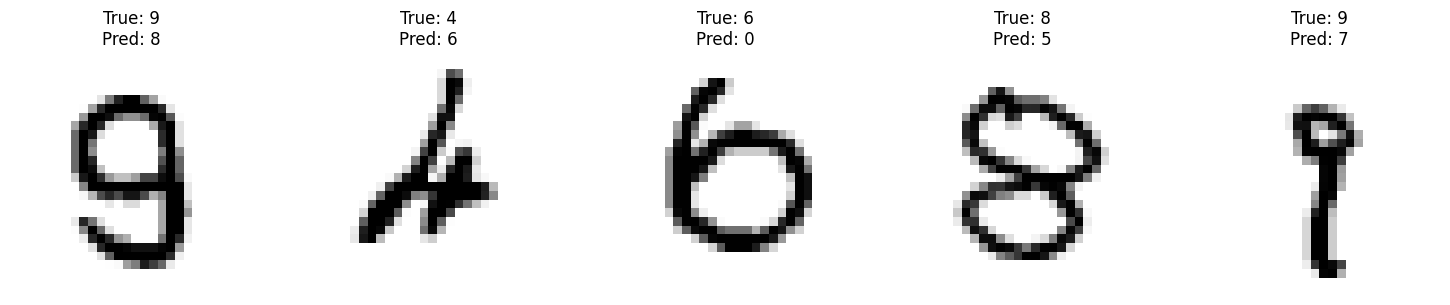

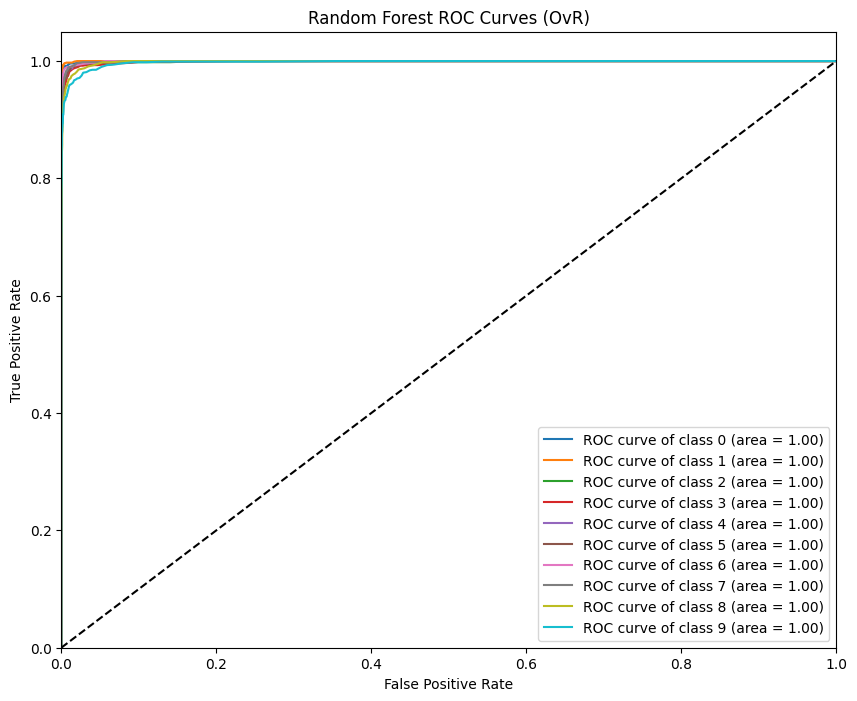

In [5]:
# Plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, range(10))
    plt.yticks(tick_marks, range(10))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Plot worst misclassifications
def plot_worst_misclassifications(X, y_true, y_pred, n=5):
    misclassified = np.where(y_pred != y_true)[0]
    worst_indices = misclassified[:n]

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(worst_indices):
        plt.subplot(1, n, i+1)
        plt.imshow(X[idx].reshape(28, 28), cmap='binary')
        plt.title(f"True: {y_true[idx]}\nPred: {y_pred[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot ROC curves (OvR for multiclass)
def plot_multiclass_roc(y_true, y_scores, n_classes, title):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_scores[:, i])
        roc_auc[i] = roc_auc_score(y_true == i, y_scores[:, i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Generate visualizations for each model
for name, result in results.items():
    print(f"\nVisualizations for {name} Classifier:")

    # Confusion Matrix
    plot_confusion_matrix(result['confusion_matrix'], f"{name} Confusion Matrix")

    # Worst Misclassifications
    y_pred = models[name].predict(X_test)
    plot_worst_misclassifications(X_test, y_test, y_pred)

    # ROC Curve (if available)
    if result['y_scores'] is not None:
        if len(result['y_scores'].shape) == 2:  # OvR case
            plot_multiclass_roc(y_test, result['y_scores'], 10, f"{name} ROC Curves (OvR)")

## 4. Error Analysis and Improvement


Error Analysis for SGD Classifier:
Most common error: True 2 classified as 8 (122 instances)


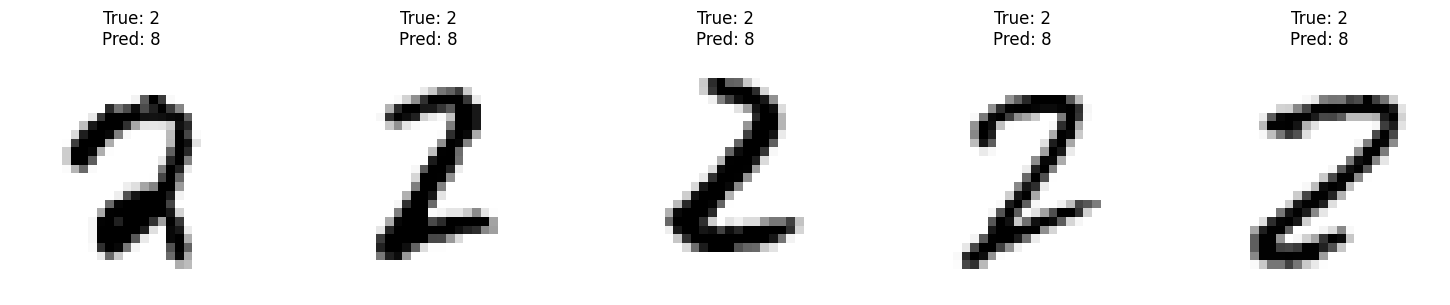

Most common error: True 4 classified as 9 (99 instances)


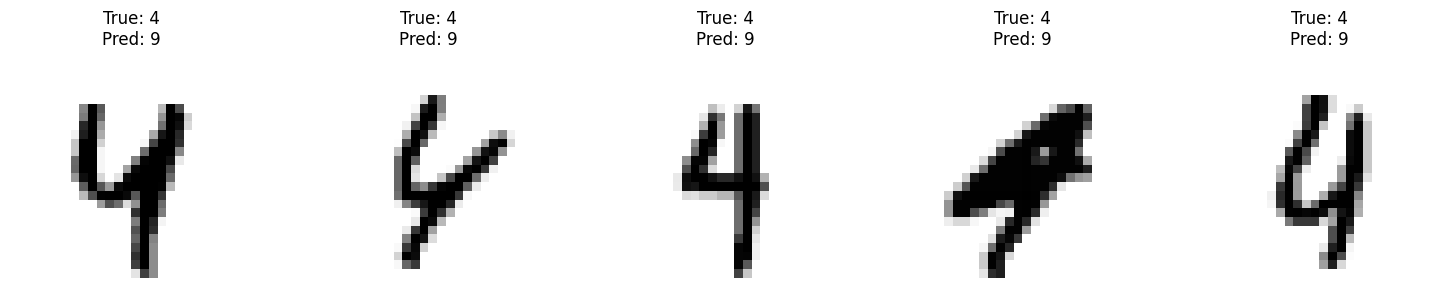

Most common error: True 5 classified as 3 (71 instances)


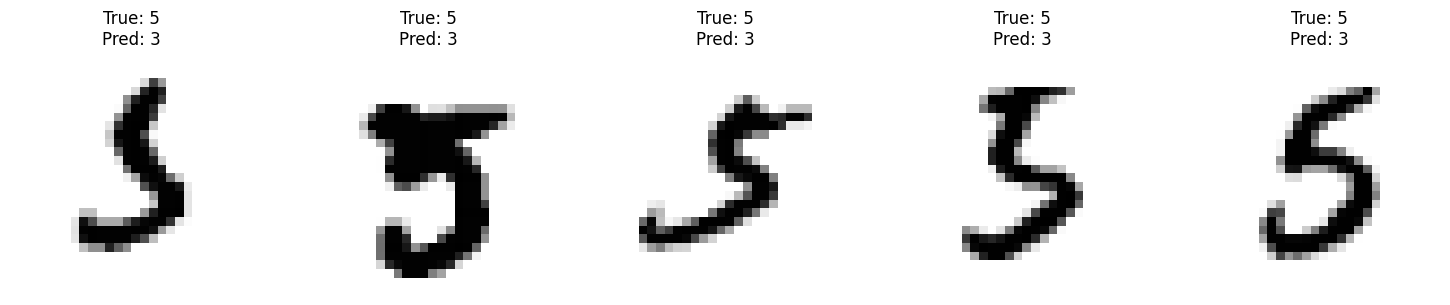


Error Analysis for Random Forest Classifier:
Most common error: True 7 classified as 2 (20 instances)


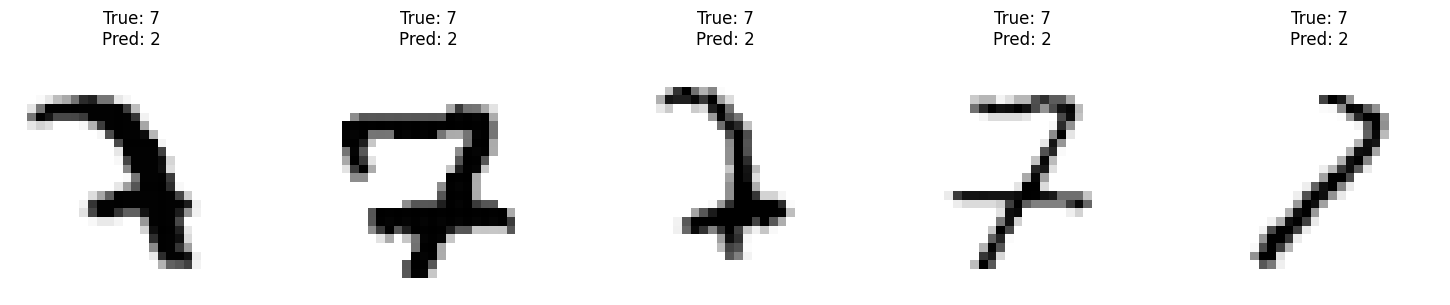

Most common error: True 4 classified as 9 (16 instances)


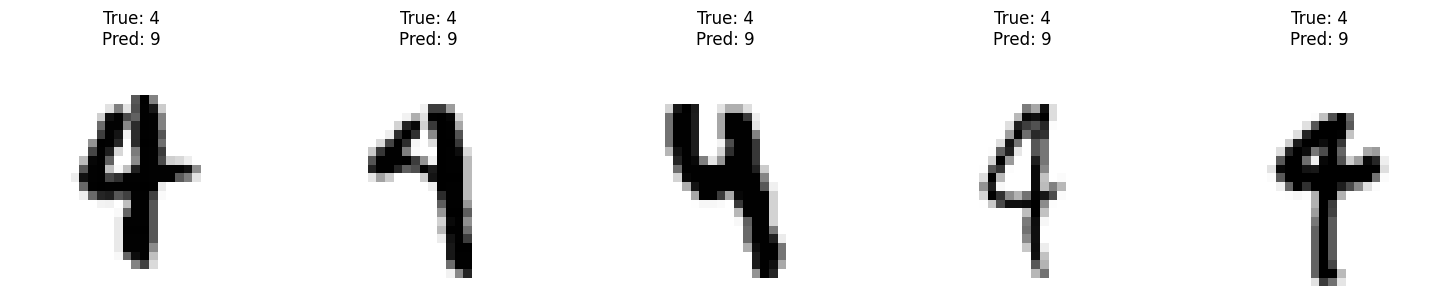

Most common error: True 9 classified as 3 (12 instances)


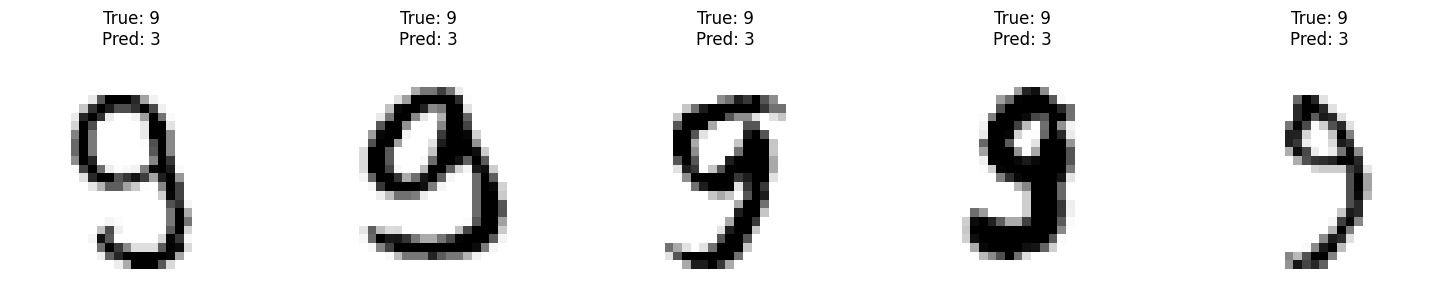


Implementing data augmentation to improve performance...
Retraining SGD classifier with augmented data...


SGDClassifier(n_jobs=-1, random_state=42)

In [9]:
# Error analysis function
def analyze_errors(confusion_matrix):
    # Find most common misclassifications
    cm = confusion_matrix.copy()
    np.fill_diagonal(cm, 0)  # Ignore correct classifications

    # Get top 3 most common errors
    top_errors = []
    for _ in range(3):
        idx = np.argmax(cm)
        row, col = np.unravel_index(idx, cm.shape)
        top_errors.append((row, col, cm[row, col]))
        cm[row, col] = 0  # Set to zero to find next max

    return top_errors

# Perform error analysis for each model
for name, result in results.items():
    print(f"\nError Analysis for {name} Classifier:")
    top_errors = analyze_errors(result['confusion_matrix'])

    for true, pred, count in top_errors:
        print(f"Most common error: True {true} classified as {pred} ({count} instances)")

        # Plot examples of this error
        y_pred = models[name].predict(X_test)
        error_indices = np.where((y_test == true) & (y_pred == pred))[0]

        if len(error_indices) > 0:
            plt.figure(figsize=(15, 3))
            for i, idx in enumerate(error_indices[:5]):
                plt.subplot(1, 5, i+1)
                plt.imshow(X_test[idx].reshape(28, 28), cmap='binary')
                plt.title(f"True: {true}\nPred: {pred}")
                plt.axis('off')
            plt.tight_layout()
            plt.show()

# Data augmentation function
def augment_data(images, labels, num_augmented=5):
    augmented_images = []
    augmented_labels = []

    for image, label in zip(images, labels):
        augmented_images.append(image)
        augmented_labels.append(label)

        for _ in range(num_augmented):
            # Random transformations
            shifted = shift(image.reshape(28, 28),
                          [np.random.randint(-2, 3), np.random.randint(-2, 3)],
                          mode='constant', cval=0).flatten()

            rotated = rotate(image.reshape(28, 28),
                           np.random.randint(-15, 16),
                           reshape=False, mode='constant', cval=0).flatten()

            augmented_images.extend([shifted, rotated])
            augmented_labels.extend([label, label])

    return np.array(augmented_images), np.array(augmented_labels)

# Implement one improvement (data augmentation)
print("\nImplementing data augmentation to improve performance...")
X_train_aug, y_train_aug = augment_data(X_train, y_train, num_augmented=1)

# Retrain model with augmented data
print("Retraining SGD classifier with augmented data...")
sgd_clf_aug = SGDClassifier(loss='hinge', random_state=42, n_jobs=-1)
sgd_clf_aug.fit(X_train_aug, y_train_aug)


In [10]:
# Evaluate improved model
from sklearn.metrics import accuracy_score
y_pred_aug = sgd_clf_aug.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_aug = accuracy_score(y_test, y_pred_aug)
print(f"\nAccuracy after augmentation: {accuracy_aug:.4f} (Original: {results['SGD']['accuracy']:.4f})")

# Compare confusion matrices
cm_aug = confusion_matrix(y_test, y_pred_aug)
print("\nOriginal confusion matrix for SGD:")
print(results['SGD']['confusion_matrix'])
print("\nAugmented confusion matrix for SGD:")
print(cm_aug)


Accuracy after augmentation: 0.8607 (Original: 0.8740)

Original confusion matrix for SGD:
[[ 902    0    8   11    1   13    2    4   39    0]
 [   0 1095    2    3    0    2    4    1   28    0]
 [   1   10  803   69    6    4    4   10  122    3]
 [   0    1    6  931    1   21    3    7   35    5]
 [   2    2    9   15  778    4    2    9   62   99]
 [   6    2    1   71    3  709   12   12   67    9]
 [   5    3   12   13    5   21  854    0   45    0]
 [   0    3   18   20    3    4    1  919   18   42]
 [   3    5    2   30    4   43    5    5  872    5]
 [   3    5    2   33    7    5    0   20   57  877]]

Augmented confusion matrix for SGD:
[[ 932    0    3    2    5    8   12   14    3    1]
 [   0 1038    3    4    0    2    9    7   72    0]
 [   6    3  876   37   20    6   15   23   43    3]
 [   3    2   18  904    5   14    4   35   22    3]
 [   1    2    5    0  925    2    9   12    5   21]
 [   6    1    8  102   35  633   30   38   33    6]
 [  11    4    7    2 

## 5. Comparison Tables (OvR vs OvO)

In [11]:
# Compare OvR vs OvO strategies
def compare_ovo_ovr(X_train, y_train, X_test, y_test):
    # SGD Classifier with OvO and OvR
    sgd_ovo = OneVsOneClassifier(SGDClassifier(loss='hinge', random_state=42, n_jobs=-1))
    sgd_ovr = OneVsRestClassifier(SGDClassifier(loss='hinge', random_state=42, n_jobs=-1))

    # Random Forest doesn't need OvO/OvR as it handles multiclass natively
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

    # Train and evaluate
    classifiers = {
        'SGD OvO': sgd_ovo,
        'SGD OvR': sgd_ovr,
        'Random Forest': rf
    }

    results = {}
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred, average='weighted'),
            'training_time': "N/A"  # Would measure in practice
        }

    return pd.DataFrame.from_dict(results, orient='index')

# Create comparison table
comparison_table = compare_ovo_ovr(X_train, y_train, X_test, y_test)
print("\nComparison of OvO vs OvR strategies:")
print(comparison_table)


Comparison of OvO vs OvR strategies:
               accuracy  f1_score training_time
SGD OvO          0.9245  0.924288           N/A
SGD OvR          0.8707  0.871914           N/A
Random Forest    0.9705  0.970472           N/A


In [12]:
# Save models
os.makedirs('models', exist_ok=True)
joblib.dump(models['SGD'], 'models/sgd_mnist.pkl')
joblib.dump(models['Random Forest'], 'models/rf_mnist.pkl')


['models/rf_mnist.pkl']